In [1]:
import os
os.environ['WANDB_DISABLED']='true'

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import pandas as pd
from datasets import Dataset

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# dataset = load_dataset("cnn_dailymail", "1.0.0")
train_df = pd.read_csv('/content/drive/MyDrive/Project/train_data.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Project/validation_data.csv')

In [7]:
test_df = pd.read_csv('/content/drive/MyDrive/Project/test_data.csv')

In [8]:
train_subset = train_df.sample(n=8000,random_state=42)
test_subset = test_df.sample(n=2000,random_state=42)
val_subset = validation_df.sample(n=100,random_state=42)

In [9]:
# Load tokenizer and model
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [10]:
# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_subset)
test_dataset = Dataset.from_pandas(test_subset)

In [11]:
# Prepare the data
def preprocess_data(data, tokenizer, max_input_length=512, max_target_length=150):
    inputs = data['article']
    targets = data['highlights']

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding=True)
    labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
# Tokenize datasets
train_dataset = train_dataset.map(lambda x: preprocess_data(x, tokenizer), batched=True)
test_dataset = test_dataset.map(lambda x: preprocess_data(x, tokenizer), batched=True)


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
columns = ['input_ids', 'attention_mask', 'labels']
train_dataset.set_format(type="torch", columns=columns)
test_dataset.set_format(type="torch", columns=columns)

In [14]:
# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Project/t5-small-summarizer",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    logging_dir="/content/drive/MyDrive/Project/logs",
    logging_steps=100,
    metric_for_best_model="loss")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
# Define data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model, # You need to pass your model here
    padding=True,  # Enable padding
    max_length=150, # specify your desired maximum length, for example 150 as seen in the traceback
)

In [16]:
# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,  # Pass the data collator to the trainer
)

<ipython-input-16-7629186d43d8>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [31]:
# trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.125200,1.109937
2,1.089600,1.076988
3,1.092800,1.070018


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr

TrainOutput(global_step=3000, training_loss=1.2806504236857097, metrics={'train_runtime': 1283.4874, 'train_samples_per_second': 18.699, 'train_steps_per_second': 2.337, 'total_flos': 3248203235328000.0, 'train_loss': 1.2806504236857097, 'epoch': 3.0})

In [17]:
model_name='/content/drive/MyDrive/Project/t5-small-summarizer/checkpoint-5000'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [18]:
sample_text = validation_df.iloc[33]['article']
# sample_text = '(CNN)  -- Three scientists won the Nobel Prize in physics on Tuesday for two breakthroughs that led to two major underpinnings of the digital age -- fiber optics and digital photography, the Royal Swedish Academy of Sciences said. Willard Boyle, left, and George Smith handle a charge-coupled device in 1974. Charles K. Kao, a British and U.S. citizen, won for "groundbreaking achievements concerning the transmission of light in fibers for optical communication." Willard S. Boyle, a Canadian and U.S. citizen, and George E. Smith, a U.S. citizen, "invented the first successful imaging technology using a digital sensor, a CCD (Charge-Coupled Device)." Kao in 1966 "made a discovery that led to a breakthrough in fiber optics. He carefully calculated how to transmit light over long distances via optical glass fibers," the academy said in a press release. Today, "optical fibers make up the circulatory system that nourishes our communication society" and "facilitate broadband communication such as the Internet," the academy said. Boyle and Smith\'s Charge-Coupled Device -- invented in 1969 -- "is the digital camera\'s electronic eye" and paved the way for digital photography. "It revolutionized photography, as light could now be captured electronically instead of on film. The digital form facilitates the processing and distribution of these images. CCD technology is also used in many medical applications, e.g. imaging the inside of the human body, both for diagnostics and for microsurgery." The Nobel Prizes are being awarded this week and next. The medicine award was handed out on Monday. The prizes for chemistry and literature will be awarded Wednesday and Thursday. The Nobel Peace Prize winner will be named on Friday, and the award in economics will be issued on Monday.'

In [57]:
inputs=tokenizer(sample_text,max_length=512, truncation=True, return_tensors='pt')

In [58]:
# summary_ids = model.generate(inputs['input_ids'], length_penalty=2.0, max_length=150, early_stopping=True)

summary_ids = model.generate(**inputs,max_length=150,temperature=0.9,  # Encourages more randomness
    top_k=50,         # Considers top 50 probable tokens
    top_p=0.9,        # Samples from the top 90% probability mass
    repetition_penalty=1.2,  # Penalizes token repetition
    early_stopping=True)


In [59]:
summary=tokenizer.decode(summary_ids[0],skip_special_tokens=True)

In [60]:
print(summary)

Google has found 80% of Internet users have looked up health information online. The trove of "medical information" is actually some dude's fan-fiction site.


In [61]:
highlight = validation_df.iloc[33]['highlights']

In [62]:
sample_text

'(CNN)When I was a child, a pale specter used to call our house most evenings, eager to chat with my doctor father about her myriad medical concerns. We called her the "White Bread Lady," a moniker she earned for one particularly inane call in which she panicked to my father after consuming white bread. She wasn\'t breaking out in hives or having any adverse effects to the bread. No, she was just concerned that some future illness could befall her given that one particular dietary decision. Although we all laughed at the time, it was with a bit of shifty-eyed shame. Because most of us (including if not particularly the illustrious Ehrlich family) have lurking within us our very own "White Bread Lady," ready to convince us that each cough, sniffle and less-than-nutritious meal might be a detriment to our health. And, naturally, that White Bread Lady looms even larger when we can type our worries into a search bar and unlock a bevy of potentially distressing information. Yup, so quoth Go

In [63]:
highlight

'According to a Pew report, 80% of Internet users have looked up health info online . Sites like Mayo Clinic and others curated by doctors are safer than online forums .'

In [53]:
sample_text

"March 10, 2015 . We're truly international in scope on Tuesday. We're visiting Italy, Russia, the United Arab Emirates, and the Himalayan Mountains. Find out who's attempting to circumnavigate the globe in a plane powered partially by the sun, and explore the mysterious appearance of craters in northern Asia. You'll also get a view of Mount Everest that was previously reserved for climbers. On this page you will find today's show Transcript and a place for you to request to be on the CNN Student News Roll Call. TRANSCRIPT . Click here to access the transcript of today's CNN Student News program. Please note that there may be a delay between the time when the video is available and when the transcript is published. CNN Student News is created by a team of journalists who consider the Common Core State Standards, national standards in different subject areas, and state standards when producing the show. ROLL CALL . For a chance to be mentioned on the next CNN Student News, comment on th

In [ ]:
summary1='Nobel Prize in physics on Tuesday for two breakthroughs. Three scientists won the Nobel Prize in physics for two breakthroughs. The breakthroughs led to two major underpinnings of the digital age -- fiber optics and digital photography. The Nobel Prizes are being awarded this week and next.'

In [23]:
!pip install rouge

In [24]:
from rouge import Rouge

In [25]:
rouge = Rouge()

In [64]:
r2=rouge.get_scores(summary,highlight)

In [65]:
r2

[{'rouge-1': {'r': 0.32142857142857145,
   'p': 0.391304347826087,
   'f': 0.35294117151864673},
  'rouge-2': {'r': 0.25, 'p': 0.30434782608695654, 'f': 0.27450979896962713},
  'rouge-l': {'r': 0.32142857142857145,
   'p': 0.391304347826087,
   'f': 0.35294117151864673}}]

In [ ]:
r1=rouge.get_scores(summary,test_df.iloc[0]['highlights'])

In [ ]:
r1

[{'rouge-1': {'r': 0.1, 'p': 0.09090909090909091, 'f': 0.09523809024943337},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.06666666666666667,
   'p': 0.06060606060606061,
   'f': 0.06349205850340175}}]

In [ ]:
b_text='A transformer model is a neural network that learns context and thus meaning by tracking relationships in sequential data like the words in this sentence. Transformer models apply an evolving set of mathematical techniques, called attention or self-attention, to detect subtle ways even distant data elements in a series influence and depend on each other. First described in a 2017 paper from Google, transformers are among the newest and one of the most powerful classes of models invented to date. They’re driving a wave of advances in machine learning some have dubbed transformer AI.Stanford researchers called transformers “foundation models” in an August 2021 paper because they see them driving a paradigm shift in AI. The “sheer scale and scope of foundation models over the last few years have stretched our imagination of what is possible,” they wrote.'

In [ ]:
b_high='Transformer models are powerful neural networks that use attention mechanisms to understand relationships in sequential data, enabling them to learn context and meaning effectively. Introduced in 2017 by Google, these models have driven significant advances in AI and are now considered foundational to the field, powering transformative innovations across various domains.'

In [ ]:
b_gen="transformer models apply an evolving set of mathematical techniques to detect subtle ways distant data elements in a series influence and depend on each other. they're driving a wave of advances in machine learning some have dubbed'transformer ai'in an august 2021 paper, stanford researchers called transformers'foundation models '"

In [ ]:
rouge.get_scores(b_gen,b_high)

[{'rouge-1': {'r': 0.13636363636363635,
   'p': 0.13953488372093023,
   'f': 0.13793102948341937},
  'rouge-2': {'r': 0.02, 'p': 0.02127659574468085, 'f': 0.02061855170581479},
  'rouge-l': {'r': 0.11363636363636363,
   'p': 0.11627906976744186,
   'f': 0.11494252373629299}}]

In [ ]:
b2h=" Ana Ivanovic penalized a game after needing an emergency toilet break in Austria . Serbian blames her pre-match snack of yyogurtafter leaving the court against rules . Seventh seed recovers to reach quarterfinals, where she will play Julia Gorges of Germany . Israeli third seed Shahar Peer reaches the last eight at the HP Japan Women's Open ."
b2g="The World No. 1 Ana Ivanovic reached the quarterfinals of the Generali Ladies Linz tournament. She was penalized for taking too long in the toilet when she left the court. The Swiss left-hander beat Austria's Aiko Nakamura 6-2 6-0. Third seed Shahar Peer will next play Julia Gorges in the HP Japan Women's Open."

In [ ]:
rouge.get_scores(b2g,b2h)

[{'rouge-1': {'r': 0.4, 'p': 0.4166666666666667, 'f': 0.408163260308205},
  'rouge-2': {'r': 0.18867924528301888,
   'p': 0.19230769230769232,
   'f': 0.19047618547664413},
  'rouge-l': {'r': 0.38, 'p': 0.3958333333333333, 'f': 0.38775509704289884}}]

count    95705.000000
mean        44.848409
std         10.829776
min          6.000000
25%         38.000000
50%         45.000000
75%         53.000000
max        190.000000
Name: summary_length, dtype: float64


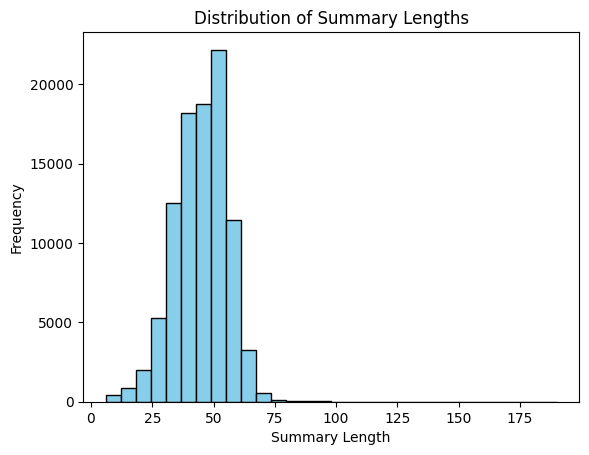

In [13]:
# Calculate the lengths of the summaries
train_df['summary_length'] = train_df['highlights'].apply(lambda x: len(x.split()))

# Summary statistics
summary_stats = train_df['summary_length'].describe()
print(summary_stats)

# Optional: Visualize the distribution
import matplotlib.pyplot as plt

plt.hist(train_df['summary_length'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.title('Distribution of Summary Lengths')
plt.show()

### If the standard deviation is large (e.g., comparable to the mean) or
###  the histogram shows a wide range of lengths, there may be inconsistency in the summary lengths.

In [19]:
# Initialize a list to store generated summaries and highlights
generated_summaries = []

# Iterate through each article in the validation dataset
for i in range(len(val_subset)):
    val_articles = val_subset.iloc[i]['article']
    highlight = val_subset.iloc[i]['highlights']

    # Tokenize the input text
    inputs = tokenizer(val_articles, max_length=512, truncation=True, return_tensors='pt')

    # Generate the summary
    summary_ids = model.generate(
        **inputs,
        max_length=150,
        temperature=0.9,  # Encourages more randomness
        top_k=50,         # Considers top 50 probable tokens
        top_p=0.9,        # Samples from the top 90% probability mass
        repetition_penalty=1.2,  # Penalizes token repetition
        early_stopping=True
    )

    # Decode the summary and append it to the list
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generated_summaries.append(summary)



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [20]:
val_summaries = val_subset['highlights'].tolist()
gen_summaries = generated_summaries

In [26]:
rouge.get_scores(gen_summaries,val_summaries,avg=True)

{'rouge-1': {'r': 0.3394325551579456,
  'p': 0.42842065731267603,
  'f': 0.36792000264859615},
 'rouge-2': {'r': 0.14818672274732728,
  'p': 0.18901363413404265,
  'f': 0.16015963326683708},
 'rouge-l': {'r': 0.320609236687546,
  'p': 0.40486731188954195,
  'f': 0.3476652580468341}}